In [101]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Loan_Prediction/Data/loan_data.csv")
# Initial peek at data
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (381, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [10]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,381.000000,381.000000,381.000000,370.000000,351.000000
mean,3579.845144,1277.275381,104.986877,340.864865,0.837607
std,1419.813818,2340.818114,28.358464,68.549257,0.369338
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2600.000000,0.000000,90.000000,360.000000,1.000000
50%,3333.000000,983.000000,110.000000,360.000000,1.000000
75%,4288.000000,2016.000000,127.000000,360.000000,1.000000
max,9703.000000,33837.000000,150.000000,480.000000,1.000000


In [11]:
df.describe(include='object')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,381,376,381,373,381,360,381,381
unique,381,2,2,4,2,2,3,2
top,LP002990,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,291,228,234,278,325,149,271


In [12]:
df.isnull().sum()

,0
Loan_ID,0
Gender,5
Married,0
Dependents,8
Education,0
Self_Employed,21
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,11


<Axes: >

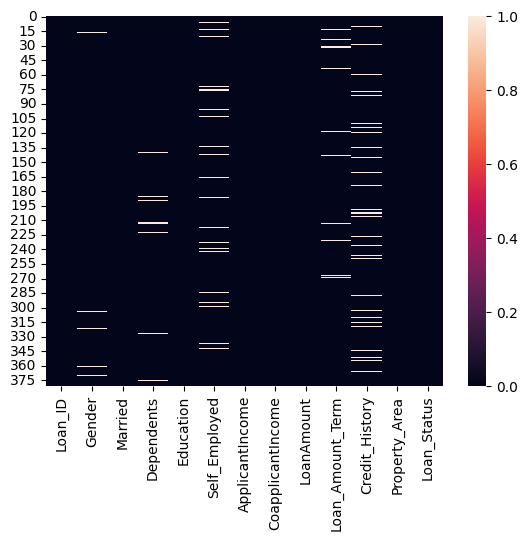

In [13]:
sns.heatmap(df.isnull())

In [14]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Loan_ID: 381 unique values
Gender: 2 unique values
Married: 2 unique values
Dependents: 4 unique values
Education: 2 unique values
Self_Employed: 2 unique values
ApplicantIncome: 322 unique values
CoapplicantIncome: 182 unique values
LoanAmount: 101 unique values
Loan_Amount_Term: 10 unique values
Credit_History: 2 unique values
Property_Area: 3 unique values
Loan_Status: 2 unique values


In [15]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical Columns:", categorical_cols)

Categorical Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


## Dealing with the missing values

# Gender, Married, and Self-Employed

In [17]:
loan_df = df.copy()
# imputation with mode for binary cat columns
for col in ['Gender', 'Married', 'Self_Employed']:
    mode_val = loan_df[col].mode()[0]
    loan_df[col] = loan_df[col].fillna(mode_val)

# Dependents

In [18]:
# to preserve ordinality, replace '3+' with '3', impute missing values with mode, and convert to int
loan_df['Dependents'] = loan_df['Dependents'].replace('3+', '3').fillna(loan_df['Dependents'].mode()[0])
loan_df['Dependents'] = loan_df['Dependents'].astype(int)


# Loan Amount

In [19]:
# there is no missing value for the LoanAmount, but we define a logic to address real-world scenario
# where there can be missing value, as it is one of the most important features
# group the rows based on the unique combinations of Education and Self_Employed, and focus on the LoanAmount column within each group
# by imputing with that combination's median LoanAmount
loan_df['LoanAmount'] = loan_df.groupby(['Education', 'Self_Employed'])['LoanAmount'].transform(
    lambda x: x.fillna(x.median())
)

# Loan Amount Term

In [20]:
# to preserve the standard loan term, we impute missing values by mode
loan_df['Loan_Amount_Term'] = loan_df['Loan_Amount_Term'].fillna(loan_df['Loan_Amount_Term'].mode()[0])

# Credit History

In [21]:
# we interpret missing credit history value as no credit history, but at the same time let the model know that this is assumed because
# there was data missing, so we add a binary flag to indicate if Credit_History was missing
loan_df['Credit_History_missing'] = loan_df['Credit_History'].isnull().astype(int)

# fill missing credit history with 0 which is interpreted as "no credit history"
loan_df['Credit_History'] = loan_df['Credit_History'].fillna(0)


In [22]:
loan_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Credit_History_missing
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,0
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,0
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,0
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,LP002953,Male,Yes,3,Graduate,No,5703,0.0,128.0,360.0,1.0,Urban,Y,0
377,LP002974,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y,0
378,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,0
379,LP002979,Male,Yes,3,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,0


In [25]:
loan_df.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


<Axes: >

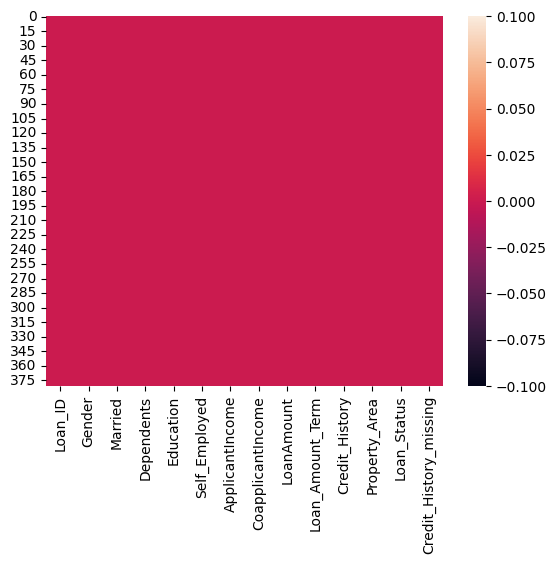

In [26]:
sns.heatmap(loan_df.isnull())

## Some feature engineering that could help


In [27]:
# create a new column with total income that is considered more relevant in the domain
loan_df['TotalIncome'] = loan_df['ApplicantIncome'] + loan_df['CoapplicantIncome']


In [28]:
loan_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Credit_History_missing,TotalIncome
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0,6091.0
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,0,3000.0
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,0,4941.0
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,0,6000.0
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,0,3849.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,LP002953,Male,Yes,3,Graduate,No,5703,0.0,128.0,360.0,1.0,Urban,Y,0,5703.0
377,LP002974,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y,0,5182.0
378,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,0,2900.0
379,LP002979,Male,Yes,3,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,0,4106.0


In [55]:
# we can include a new feature to estimate monthly installment pay
loan_df['EMI'] = loan_df['LoanAmount']*1000 / loan_df['Loan_Amount_Term']

In [56]:
# new feature to estimate risk. High ratio = higher risk and vice-versa. Avoid division by zero.
loan_df['LoanToIncomeRatio'] = loan_df['LoanAmount']*1000 / (loan_df['TotalIncome'] + 1e-6)

In [57]:
# log transform skewed features to reduce outliers' impact
loan_df['LoanAmount_log'] = np.log1p(loan_df['LoanAmount'])
loan_df['TotalIncome_log'] = np.log1p(loan_df['TotalIncome'])


In [58]:
loan_df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Credit_History_missing,TotalIncome,EMI,LoanToIncomeRatio,TotalIncome_log,HasCoapplicant,LoanAmount_log
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0,6091.0,355.555556,21.014612,8.714732,1,4.859812
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,0,3000.0,183.333333,22.000000,8.006701,0,4.204693
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,0,4941.0,333.333333,24.286582,8.505525,1,4.795791
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,0,6000.0,391.666667,23.500000,8.699681,0,4.955827
4,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,0,3849.0,263.888889,24.681736,8.255828,1,4.564348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Male,Yes,3,Graduate,No,5703,0.0,128.0,360.0,1.0,Urban,Y,0,5703.0,355.555556,22.444328,8.648923,0,4.859812
377,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y,0,5182.0,300.000000,20.841374,8.553139,1,4.691348
378,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,0,2900.0,197.222222,24.482759,7.972811,0,4.276666
379,Male,Yes,3,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,0,4106.0,222.222222,9.741841,8.320448,0,3.713572


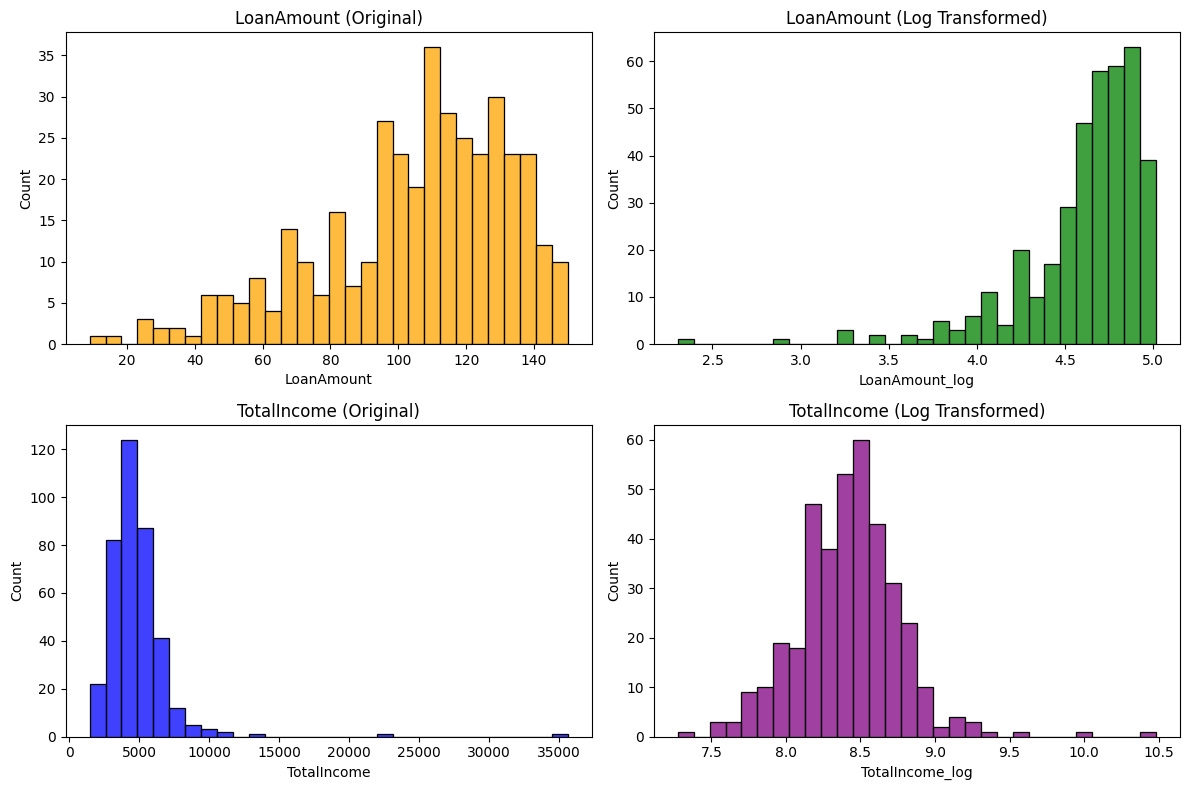

In [59]:
# original vs log transoformed plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(loan_df['LoanAmount'], bins=30, ax=axes[0, 0], color='orange')
axes[0, 0].set_title('LoanAmount (Original)')
sns.histplot(loan_df['LoanAmount_log'], bins=30, ax=axes[0, 1], color='green')
axes[0, 1].set_title('LoanAmount (Log Transformed)')

sns.histplot(loan_df['TotalIncome'], bins=30, ax=axes[1, 0], color='blue')
axes[1, 0].set_title('TotalIncome (Original)')
sns.histplot(loan_df['TotalIncome_log'], bins=30, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('TotalIncome (Log Transformed)')

plt.tight_layout()
plt.show()

In [60]:
# Loan amount doesn't seem to need log transformation, so drop the transformed column
loan_df.drop(columns=['LoanAmount_log'], inplace=True)

In [ ]:
loan_df.drop(columns=['Loan_ID'], inplace=True)

In [62]:
loan_df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Credit_History_missing,TotalIncome,EMI,LoanToIncomeRatio,TotalIncome_log,HasCoapplicant
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0,6091.0,355.555556,21.014612,8.714732,1
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,0,3000.0,183.333333,22.000000,8.006701,0
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,0,4941.0,333.333333,24.286582,8.505525,1
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,0,6000.0,391.666667,23.500000,8.699681,0
4,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,0,3849.0,263.888889,24.681736,8.255828,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Male,Yes,3,Graduate,No,5703,0.0,128.0,360.0,1.0,Urban,Y,0,5703.0,355.555556,22.444328,8.648923,0
377,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y,0,5182.0,300.000000,20.841374,8.553139,1
378,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,0,2900.0,197.222222,24.482759,7.972811,0
379,Male,Yes,3,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,0,4106.0,222.222222,9.741841,8.320448,0


# Exploratory Analysis

Credit History vs. Loan Status

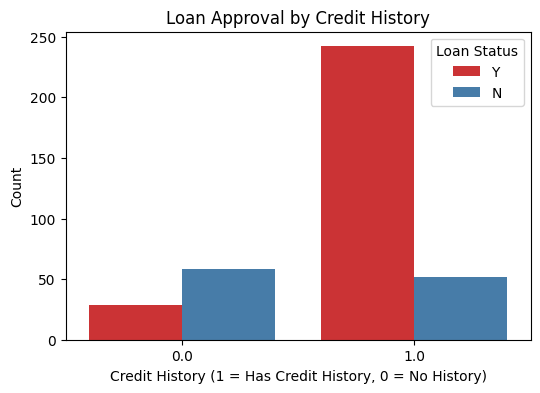

Approval Rates by Credit History:


Loan_Status,N,Y
Credit_History,,
0.0,0.666667,0.333333
1.0,0.176871,0.823129


In [38]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loan_df, x='Credit_History', hue='Loan_Status', palette='Set1')
plt.title('Loan Approval by Credit History')
plt.xlabel('Credit History (1 = Has Credit History, 0 = No History)')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

# Percentage approved per credit history group
approval_by_credit = pd.crosstab(loan_df['Credit_History'], loan_df['Loan_Status'], normalize='index')
print("Approval Rates by Credit History:")
display(approval_by_credit)

 Applicants with credit history were approved at 82%, compared to only 33% for those without. This tells that Credit_History should be a key feature

Property Area vs Loan Status

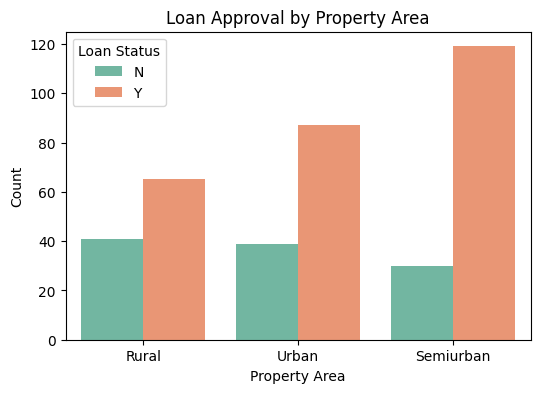

Approval Rates by Property Area:


Loan_Status,N,Y
Property_Area,,
Rural,0.386792,0.613208
Semiurban,0.201342,0.798658
Urban,0.309524,0.690476


In [39]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loan_df, x='Property_Area', hue='Loan_Status', palette='Set2')
plt.title('Loan Approval by Property Area')
plt.xlabel('Property Area')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

# Percentage approved by Property_Area
approval_by_area = pd.crosstab(loan_df['Property_Area'], loan_df['Loan_Status'], normalize='index')
print("Approval Rates by Property Area:")
display(approval_by_area)

Property_Area seems to be moderately predictive, so we do not drop it.

Education vs Loan Status

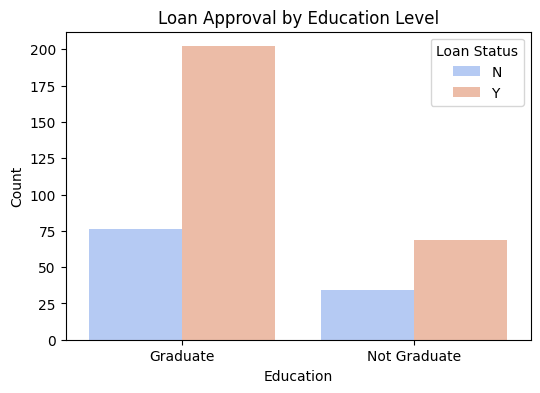

Approval Rates by Education Level:


Loan_Status,N,Y
Education,,
Graduate,0.273381,0.726619
Not Graduate,0.330097,0.669903


In [40]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loan_df, x='Education', hue='Loan_Status', palette='coolwarm')
plt.title('Loan Approval by Education Level')
plt.xlabel('Education')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

# Approval rate by education level
approval_by_edu = pd.crosstab(loan_df['Education'], loan_df['Loan_Status'], normalize='index')
print("Approval Rates by Education Level:")
display(approval_by_edu)

Education has a small but consistent influence on loan approval

Self_Employed vs Loan Status

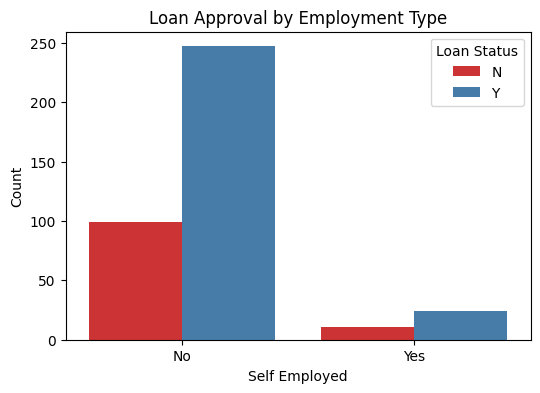

Approval Rates by Employment Status:


Loan_Status,N,Y
Self_Employed,,
No,0.286127,0.713873
Yes,0.314286,0.685714


In [41]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loan_df, x='Self_Employed', hue='Loan_Status', palette='Set1')
plt.title('Loan Approval by Employment Type')
plt.xlabel('Self Employed')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

# Approval rate by employment status
approval_by_emp = pd.crosstab(loan_df['Self_Employed'], loan_df['Loan_Status'], normalize='index')
print("Approval Rates by Employment Status:")
display(approval_by_emp)

 While not strongly predictive on its own, let's keep it in the model due to its potential for interaction and because it doesn’t increase model complexity.

Total Income

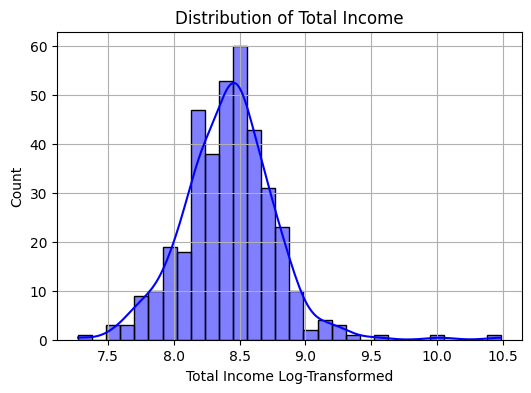

In [66]:
plt.figure(figsize=(6, 4))
sns.histplot(loan_df['TotalIncome_log'], bins=30, kde=True, color='blue')
plt.title('Distribution of Total Income')
plt.xlabel('Total Income Log-Transformed')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Distribution of Applicant Income

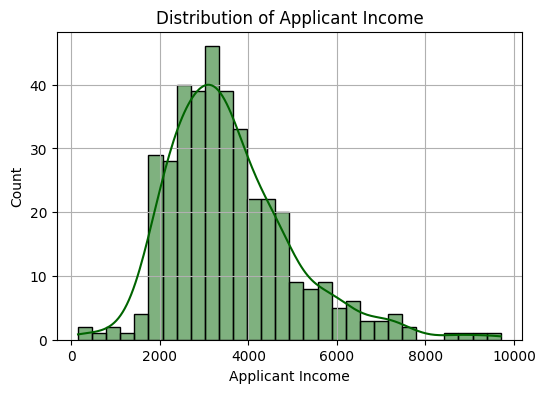

In [67]:
plt.figure(figsize=(6, 4))
sns.histplot(loan_df['ApplicantIncome'], bins=30, kde=True, color='darkgreen')
plt.title('Distribution of Applicant Income')
plt.xlabel('Applicant Income')
plt.ylabel('Count')
plt.grid(True)
plt.show()

THis can be kept as supplemental feature that we test later

Distribution of Coapplicant Income

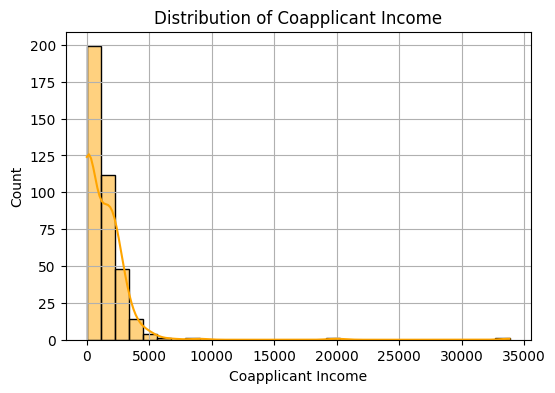

In [68]:
plt.figure(figsize=(6, 4))
sns.histplot(loan_df['CoapplicantIncome'], bins=30, kde=True, color='orange')
plt.title('Distribution of Coapplicant Income')
plt.xlabel('Coapplicant Income')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Good for tree-based models, but we can create another feature for linear models.

In [69]:
loan_df['HasCoapplicant'] = (loan_df['CoapplicantIncome'] > 0).astype(int)

In [70]:
loan_df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Credit_History_missing,TotalIncome,EMI,LoanToIncomeRatio,TotalIncome_log,HasCoapplicant
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0,6091.0,355.555556,21.014612,8.714732,1
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,0,3000.0,183.333333,22.000000,8.006701,0
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,0,4941.0,333.333333,24.286582,8.505525,1
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,0,6000.0,391.666667,23.500000,8.699681,0
4,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,0,3849.0,263.888889,24.681736,8.255828,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Male,Yes,3,Graduate,No,5703,0.0,128.0,360.0,1.0,Urban,Y,0,5703.0,355.555556,22.444328,8.648923,0
377,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y,0,5182.0,300.000000,20.841374,8.553139,1
378,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,0,2900.0,197.222222,24.482759,7.972811,0
379,Male,Yes,3,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,0,4106.0,222.222222,9.741841,8.320448,0


/tmp/ipython-input-71-3245884715.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=loan_df['HasCoapplicant'], palette='Set2')


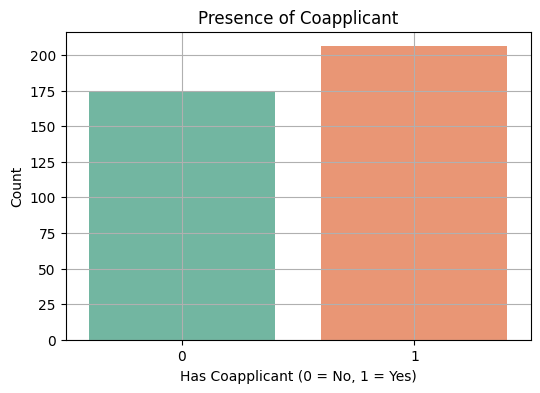

In [71]:
plt.figure(figsize=(6, 4))
sns.countplot(x=loan_df['HasCoapplicant'], palette='Set2')
plt.title('Presence of Coapplicant')
plt.xlabel('Has Coapplicant (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Distribution of LoanAmount

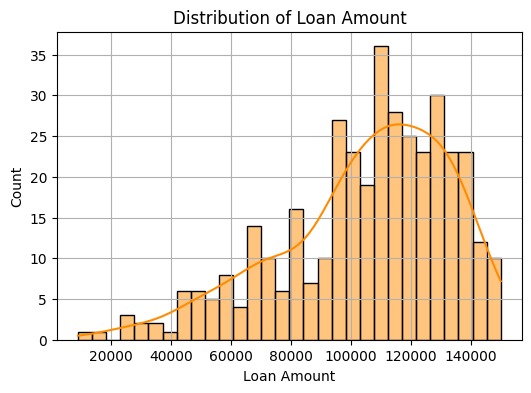

In [72]:
plt.figure(figsize=(6, 4))
sns.histplot(loan_df['LoanAmount']*1000, bins=30, kde=True, color='darkorange')
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.grid(True)
plt.show()

 Loan-to-Income Ratio

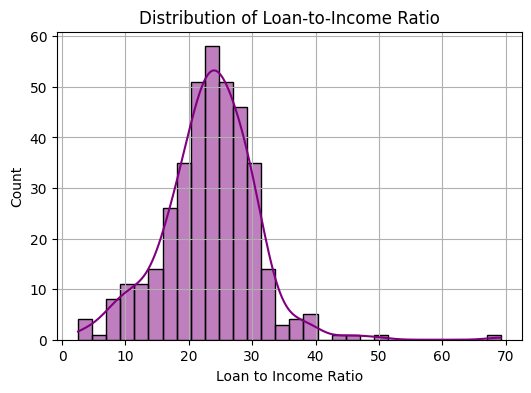

In [73]:
plt.figure(figsize=(6, 4))
sns.histplot(loan_df['LoanToIncomeRatio'], bins=30, kde=True, color='purple')
plt.title('Distribution of Loan-to-Income Ratio')
plt.xlabel('Loan to Income Ratio')
plt.ylabel('Count')
plt.grid(True)
plt.show()


The distribution shows most people are within safe borrowing ranges, but some are overextended.

Ratio by Loan Status

/tmp/ipython-input-74-3586565831.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Loan_Status', y='LoanToIncomeRatio', data=loan_df, palette='Set3')


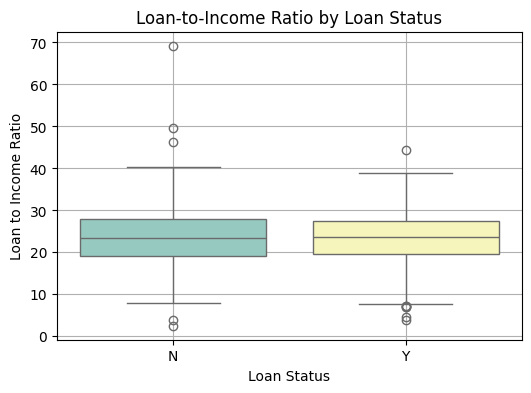

In [74]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Loan_Status', y='LoanToIncomeRatio', data=loan_df, palette='Set3')
plt.title('Loan-to-Income Ratio by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan to Income Ratio')
plt.grid(True)
plt.show()

The distribution revealed that approved applicants tend to borrow a smaller portion of their income with fewer outliers. This aligns with financial risk expectations and justifies including this feature in the model.

In [75]:
loan_df.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Credit_History_missing,TotalIncome,EMI,LoanToIncomeRatio,TotalIncome_log,HasCoapplicant
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,0.666667,3579.845144,1277.275381,104.986877,341.417323,0.771654,0.078740,4857.120525,354.850175,23.354106,8.419002,0.540682
std,0.987643,1419.813818,2340.818114,28.358464,67.625957,0.420319,0.269687,2417.069533,498.730596,7.284367,0.350541,0.498997
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000,1442.000000,25.000000,2.522916,7.274480,0.000000
25%,0.000000,2600.000000,0.000000,90.000000,360.000000,1.000000,0.000000,3664.000000,256.250000,19.414049,8.206584,0.000000
50%,0.000000,3333.000000,983.000000,110.000000,360.000000,1.000000,0.000000,4600.000000,311.111111,23.612158,8.434029,1.000000
75%,1.000000,4288.000000,2016.000000,127.000000,360.000000,1.000000,0.000000,5500.000000,363.888889,27.695125,8.612685,1.000000
max,3.000000,9703.000000,33837.000000,150.000000,480.000000,1.000000,1.000000,35673.000000,9250.000000,69.230769,10.482177,1.000000


EMI vs Loan Status

/tmp/ipython-input-76-161124098.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=loan_df, x='Loan_Status', y='EMI', palette='Set2')


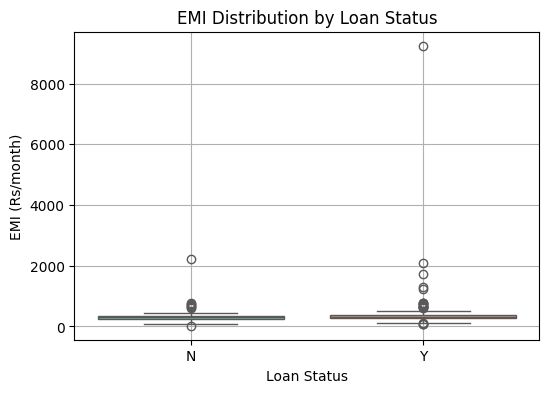

In [76]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=loan_df, x='Loan_Status', y='EMI', palette='Set2')
plt.title('EMI Distribution by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('EMI (Rs/month)')
plt.grid(True)
plt.show()

This suggests EMI is not a decisive factor on its own but needs to be evaluated relative to income

Loan_Amount_Term distribution

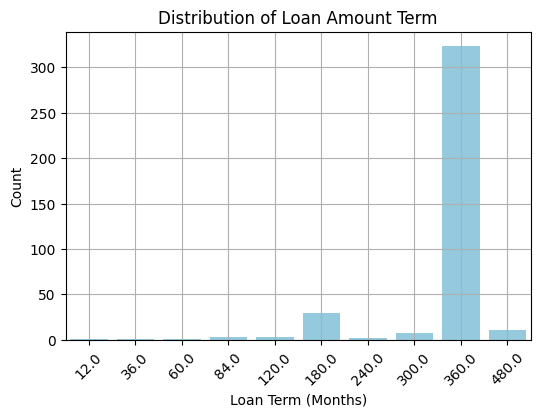

In [77]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loan_df, x='Loan_Amount_Term', color='skyblue')
plt.title('Distribution of Loan Amount Term')
plt.xlabel('Loan Term (Months)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

This can be treated as a cat variable

Dependents


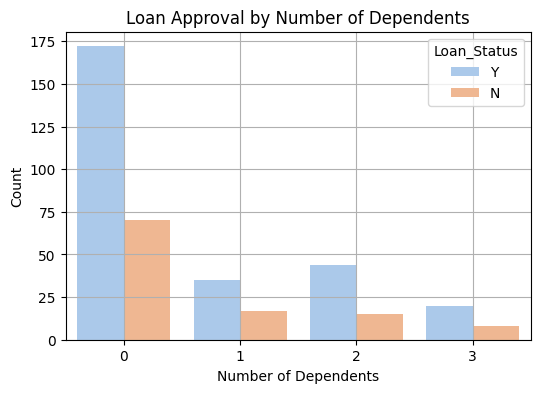

In [79]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loan_df, x='Dependents', hue='Loan_Status', palette='pastel')
plt.title('Loan Approval by Number of Dependents')
plt.xlabel('Number of Dependents')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [80]:
print("Approval Rates by Number of Dependents:")
display(pd.crosstab(loan_df['Dependents'], loan_df['Loan_Status'], normalize='index'))


Approval Rates by Number of Dependents:


Loan_Status,N,Y
Dependents,,
0,0.289256,0.710744
1,0.326923,0.673077
2,0.254237,0.745763
3,0.285714,0.714286


Gender

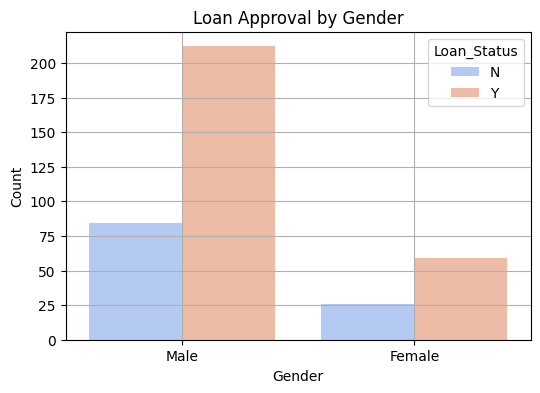

In [81]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loan_df, x='Gender', hue='Loan_Status', palette='coolwarm')
plt.title('Loan Approval by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [82]:
print("Approval Rates by Gender:")
display(pd.crosstab(loan_df['Gender'], loan_df['Loan_Status'], normalize='index'))


Approval Rates by Gender:


Loan_Status,N,Y
Gender,,
Female,0.305882,0.694118
Male,0.283784,0.716216


Gender is mildly predictive alone but may show value when combined with other features in a model

Married

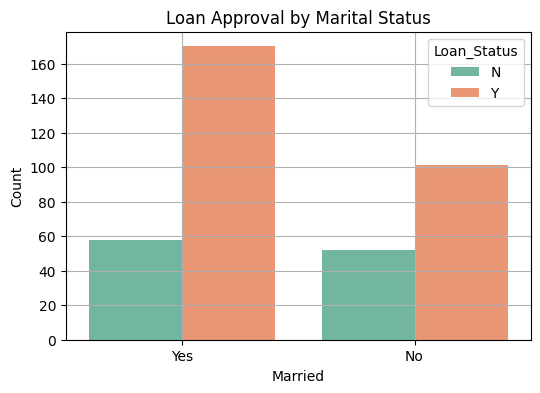

In [83]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loan_df, x='Married', hue='Loan_Status', palette='Set2')
plt.title('Loan Approval by Marital Status')
plt.xlabel('Married')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [84]:
print("Approval Rates by Marital Status:")
display(pd.crosstab(loan_df['Married'], loan_df['Loan_Status'], normalize='index'))

Approval Rates by Marital Status:


Loan_Status,N,Y
Married,,
No,0.339869,0.660131
Yes,0.254386,0.745614


Married applicants have a noticeably higher approval rate

Target Distribution

/tmp/ipython-input-85-1123306180.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=loan_df, x='Loan_Status', palette='pastel')


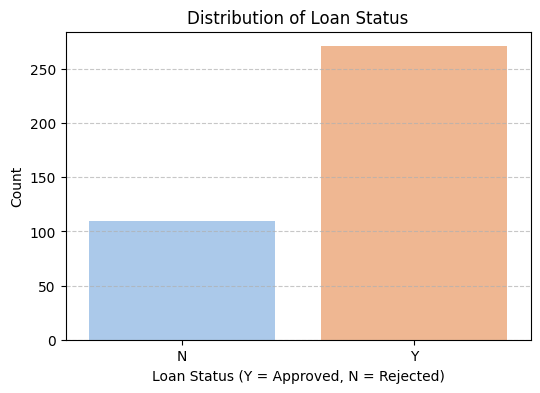

Loan Status Proportions:
Loan_Status
Y    0.711286
N    0.288714
Name: proportion, dtype: float64


In [85]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loan_df, x='Loan_Status', palette='pastel')
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status (Y = Approved, N = Rejected)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Also print proportions
loan_status_distribution = loan_df['Loan_Status'].value_counts(normalize=True)
print("Loan Status Proportions:")
print(loan_status_distribution)

In [86]:
loan_df.to_csv("loan_df_cleaned.csv", index=False)

Correlation between features

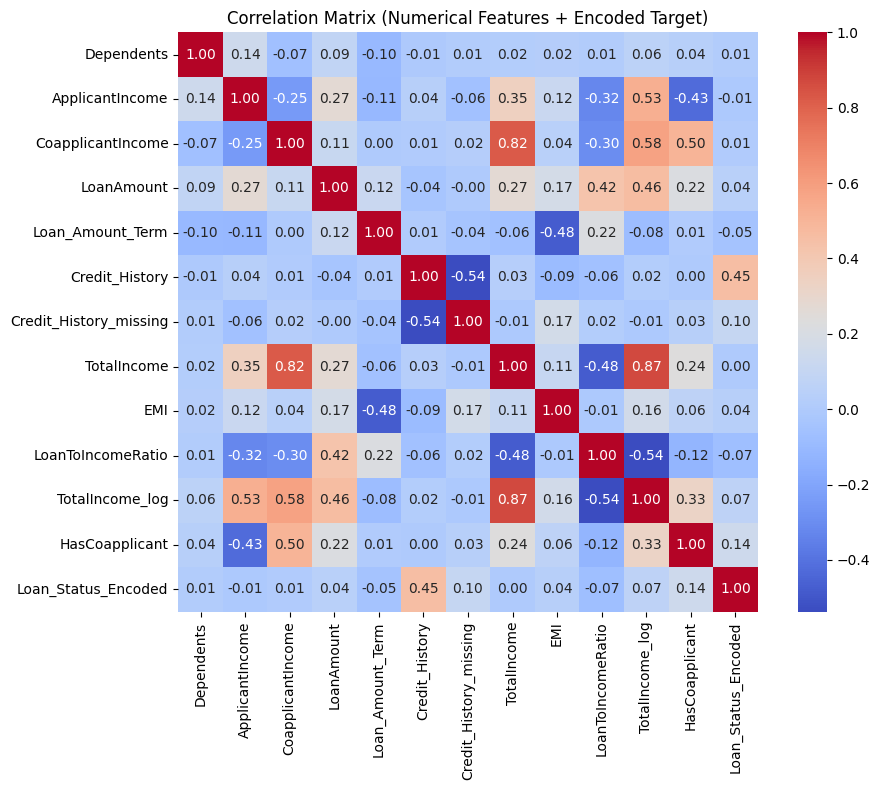

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# encode target variable for correlation
loan_df['Loan_Status_Encoded'] = loan_df['Loan_Status'].map({'N': 0, 'Y': 1})

# just numerical features
numeric_df = loan_df.select_dtypes(include='number')

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Matrix (Numerical Features + Encoded Target)")
plt.tight_layout()
plt.show()


In [89]:
loan_df.drop(columns=['ApplicantIncome', 'CoapplicantIncome', 'TotalIncome'], inplace=True)

Highly correlated features to totaol income dropped. Total income transformed kept.

## Encode cat variables

In [91]:
loan_encoded_df = loan_df.copy()

# Binary label encoding
binary_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'HasCoapplicant', 'Loan_Status']
le = LabelEncoder()

for col in binary_cols:
    loan_encoded_df[col] = le.fit_transform(loan_encoded_df[col])


In [92]:
# One-Hot Encode 'Property_Area' and 'Dependents'
loan_encoded_df = pd.get_dummies(loan_encoded_df, columns=['Property_Area', 'Dependents'], drop_first=True)

print("Encoded DataFrame shape:", loan_encoded_df.shape)
loan_encoded_df.head()


Encoded DataFrame shape: (381, 19)


,Gender,Married,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Credit_History_missing,EMI,LoanToIncomeRatio,TotalIncome_log,HasCoapplicant,Loan_Status_Encoded,Property_Area_Semiurban,Property_Area_Urban,Dependents_1,Dependents_2,Dependents_3
0,1,1,0,0,128.0,360.0,1.0,0,0,355.555556,21.014612,8.714732,1,0,False,False,True,False,False
1,1,1,0,1,66.0,360.0,1.0,1,0,183.333333,22.000000,8.006701,0,1,False,True,False,False,False
2,1,1,1,0,120.0,360.0,1.0,1,0,333.333333,24.286582,8.505525,1,1,False,True,False,False,False
3,1,0,0,0,141.0,360.0,1.0,1,0,391.666667,23.500000,8.699681,0,1,False,True,False,False,False
4,1,1,1,0,95.0,360.0,1.0,1,0,263.888889,24.681736,8.255828,1,1,False,True,False,False,False


In [96]:
loan_encoded_df.drop(columns='Loan_Status_Encoded', inplace=True)

In [110]:
columns_to_scale = [
    'LoanAmount',
    'Loan_Amount_Term',
    'EMI',
    'LoanToIncomeRatio',
    'TotalIncome_log'
]

scaler = StandardScaler()
loan_encoded_df[columns_to_scale] = scaler.fit_transform(loan_encoded_df[columns_to_scale])

In [114]:
loan_encoded_df.describe()

,Gender,Married,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Credit_History_missing,EMI,LoanToIncomeRatio,TotalIncome_log,HasCoapplicant
count,381.000000,381.000000,381.000000,381.000000,3.810000e+02,3.810000e+02,381.000000,381.000000,381.000000,3.810000e+02,3.810000e+02,3.810000e+02,381.000000
mean,0.776903,0.598425,0.270341,0.091864,-1.049030e-16,-2.424424e-16,0.771654,0.711286,0.078740,-6.993531e-17,7.226649e-17,3.698121e-15,0.540682
std,0.416870,0.490861,0.444720,0.289213,1.001315e+00,1.001315e+00,0.420319,0.453761,0.269687,1.001315e+00,1.001315e+00,1.001315e+00,0.498997
min,0.000000,0.000000,0.000000,0.000000,-3.389221e+00,-4.877572e+00,0.000000,0.000000,0.000000,-6.622491e-01,-2.863472e+00,-3.269313e+00,0.000000
25%,1.000000,0.000000,0.000000,0.000000,-5.291748e-01,2.751475e-01,1.000000,0.000000,0.000000,-1.979622e-01,-5.416035e-01,-6.067705e-01,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.770094e-01,2.751475e-01,1.000000,1.000000,0.000000,-8.781610e-02,3.547202e-02,4.292389e-02,1.000000
75%,1.000000,1.000000,1.000000,0.000000,7.772660e-01,2.751475e-01,1.000000,1.000000,0.000000,1.814727e-02,5.967200e-01,5.532529e-01,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.589378e+00,2.051947e+00,1.000000,1.000000,1.000000,1.785903e+01,6.306243e+00,5.893431e+00,1.000000


Training

In [111]:
X = loan_encoded_df.drop(columns='Loan_Status')
y = loan_encoded_df['Loan_Status']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [113]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
xgb = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train and evaluate
for name, model in zip(['Random Forest', 'Logistic Regression', 'XGBoost'], [rf, lr, xgb]):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n📌 {name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))


📌 Random Forest
Accuracy: 0.8831168831168831
              precision    recall  f1-score   support

           0       1.00      0.59      0.74        22
           1       0.86      1.00      0.92        55

    accuracy                           0.88        77
   macro avg       0.93      0.80      0.83        77
weighted avg       0.90      0.88      0.87        77


📌 Logistic Regression
Accuracy: 0.8441558441558441
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        22
           1       0.89      0.89      0.89        55

    accuracy                           0.84        77
   macro avg       0.81      0.81      0.81        77
weighted avg       0.84      0.84      0.84        77


📌 XGBoost
Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.72      0.59      0.65        22
           1       0.85      0.91      0.88        55

    accuracy                           0.82 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:49:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
